## Executive Summary

This notebook explores the modeling of daily stock excess growth rates using Hidden Markov Models (HMMs). The analysis proceeds in two main stages:
1.  A standard HMM is built from historical in-sample data.
2.  This model is then tested against well-known "stylized facts" of financial returns, revealing its strengths (capturing return distributions) and weaknesses (failing to capture volatility clustering).

To address these weaknesses, a modified HMM that incorporates price jumps is introduced and analyzed in `HMM-WithJumps-Simulation-Notebook`

 # Build a Hidden Markov Model of Daily Stock Excess Growth Rate
We are constructing an Observable Markov Model (OMM) of the excess growth rate of a ticker `XYZ` where we define the excess growth as:
$$
\begin{equation*}
R_{ij} \equiv \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{i,j}}{S_{i,j-1}}\right) - \bar{r}_{f}
\end{equation*}
$$
where $R_{ij}$ denotes the excess growth rate of equity $i$ at time $j$, $\Delta{t}$ denotes the time-step between $j-1\rightarrow{j}$ (units: years), $S_{i,\star}$ denotes the share price of equity $i$ at time $\star$, and $\bar{r}_{f}$ denotes the annualized risk free rate. In this work, we build a model of daily return.

## Model
Describe the day-to-day variation of the excess growth using a fully observable Markov model $\mathcal{M}$ represented by the tuple $\mathcal{M} = (\mathcal{S},\mathcal{O},\mathbf{P},\mathbf{E})$; $\mathcal{S}$ is the set of hidden states, $\mathcal{O}$ is the set of observable states, $\mathbf{T}$ is the transition matrix, i.e., $t_{ij}\in\mathbf{T}$ is the probability of moving from hidden state $i$ to hidden state $j$ in the next time step, and $\mathbf{E}$ is the emission matrix. Because we are fully observable, the emission matrix $\mathbf{E} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

## Objectives
- **Task 1:** Characterize the continuous distribution of returns using MLE and MCMC, then discretize this distribution to build a Hidden Markov Model (HMM).
- **Task 2:** Simulate the standard HMM and analyze its ability to reproduce key stylized facts of financial returns, particularly volatility clustering.
- **Task 3:** Save the final model artifacts for future use.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
   Installed OptimizationBase ─ v2.13.2
    Updating `~/Desktop/Project-Repos/HMM-withJumps/Project.toml`
  [5ae59095] + Colors v0.13.1
  [a93c6f00] + DataFrames v1.8.0
  [b4f34e82] + Distances v0.10.12
  [31c24e10] + Distributions v0.25.122
  [5789e2e9] + FileIO v1.17.1
  [09f84164] + HypothesisTests v0.11.5
⌃ [033835bb] + JLD2 v0.5.15
  [91a5bcdd] + Plots v1.41.1
  [92933f4c] + ProgressMeter v1.11.0
  [10745b16] + Statistics v1.11.1
  [2913bbd2] + StatsBase v0.34.6
  [f3b207a7] + StatsPlots v0.15.8
  [fce5fe82] + Turing v0.40.4
  [4119e0bf] + VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
  [37e2e46d] ~ LinearAlgebra ⇒ v1.12.0
    Updating `~/Desktop/Project-Repos/HMM-withJumps/Manifest.toml`
  [47edcb42] + ADTypes v1.18.0
  [621f4979] + AbstractFFTs v1.5.0
  [80f14c24] + AbstractMCMC v5.8.2
  [7a57a

## Setting Up Constants

In [2]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 100; # number of potential futures should we look at
ticker = "AAPL"; # This is the ticker we want to explore

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `02-07-2025`, along with data for a few exchange-traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data; store the cleaned data in the `dataset` variable. We then calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in the `dataset.` Finally, you'll select a firm by changing the value in the `ticker` variable. We store the computed excess return for the `ticker` in the `Rᵢ` variable.

### Load the training data

The dataset for this analysis consists of daily open-high-low-close (OHLC) data for firms in the S&P 500, spanning from **January 3, 2014, to February 7, 2025**. This data was cleaned and split into training and testing sets in a separate preprocessing step.

We begin by loading the pre-cleaned **training dataset** below.

In [3]:
train_dataset = MyPortfolioDataSet() |> x->x["train_dataset"]

Dict{String, DataFrame} with 424 entries:
  "EMR"  => 2515×8 DataFrame…
  "CTAS" => 2515×8 DataFrame…
  "HSIC" => 2515×8 DataFrame…
  "KIM"  => 2515×8 DataFrame…
  "PLD"  => 2515×8 DataFrame…
  "IEX"  => 2515×8 DataFrame…
  "BAC"  => 2515×8 DataFrame…
  "CBOE" => 2515×8 DataFrame…
  "EXR"  => 2515×8 DataFrame…
  "NCLH" => 2515×8 DataFrame…
  "CVS"  => 2515×8 DataFrame…
  "DRI"  => 2515×8 DataFrame…
  "DTE"  => 2515×8 DataFrame…
  "ZION" => 2515×8 DataFrame…
  "AVY"  => 2515×8 DataFrame…
  "EW"   => 2515×8 DataFrame…
  "EA"   => 2515×8 DataFrame…
  "NWSA" => 2515×8 DataFrame…
  "CAG"  => 2515×8 DataFrame…
  "GILD" => 2515×8 DataFrame…
  "FCX"  => 2515×8 DataFrame…
  "GPC"  => 2515×8 DataFrame…
  "UNP"  => 2515×8 DataFrame…
  "CDW"  => 2515×8 DataFrame…
  "SBUX" => 2515×8 DataFrame…
  ⋮      => ⋮

In [4]:
train_dataset["AAPL"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,3.93215e8,19.4749,19.745,19.3207,19.775,19.3011,2014-01-03T05:00:00,148584
2,4.13437e8,19.3213,19.1946,19.4261,19.5286,19.0571,2014-01-06T05:00:00,131664
3,3.17731e8,19.3329,19.44,19.2871,19.4986,19.2116,2014-01-07T05:00:00,107327
4,2.58747e8,19.4038,19.2432,19.4093,19.4843,19.2389,2014-01-08T05:00:00,86874
5,2.79621e8,19.2943,19.5286,19.1614,19.5307,19.1196,2014-01-09T05:00:00,93562
6,3.05283e8,19.0659,19.2796,19.0336,19.3143,18.9682,2014-01-10T05:00:00,113063
7,3.79443e8,19.1801,18.9254,19.1332,19.375,18.9243,2014-01-13T05:00:00,130227
8,3.34937e8,19.4033,19.2221,19.5139,19.5261,19.2021,2014-01-14T05:00:00,114856
9,3.9389e8,19.9105,19.7686,19.9057,20.0071,19.7021,2014-01-15T05:00:00,136942


In [5]:
maximum_number_trading_days = nrow(train_dataset["AAPL"])

2515

In [6]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ train_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end

Lastly, let's get a sorted list of firms that we have in cleaned up `dataset` and save it in the `list_of_all_tickers::Array{String,1}` array

In [7]:
list_of_all_tickers = keys(dataset) |> collect |> x->sort(x)

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

We compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix).
* The result is stored in the `all_firms_return_matrix::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [8]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers,
    Δt = Δt, risk_free_rate = risk_free_rate)

2514×424 Matrix{Float64}:
 -0.919654   6.23895   -2.91307    …  -0.797491   0.203794  -1.04737
  2.77416    1.02939    1.35029        2.09622   -0.84489    0.944368
  3.27095    0.813497  -0.036732       0.067777   1.1489    -2.62354
  0.604325  17.2178     1.65005        0.232616   3.1172    -0.410328
  1.77399    2.53751    3.27714        0.579577  -2.2108     4.36099
  0.57173   -4.00594   -0.83488    …  -0.904839  -1.95187   -3.15834
  2.81861   -0.525851   4.80363        1.7236    -1.81895   -1.1317
  2.00461    0.971404   1.86599        1.63387    4.40774   -0.179919
  1.27079    1.63203    0.0651592     -1.54918   -2.17906    1.39574
  1.17806    6.08747    0.890478      -1.57412    2.83574   -1.47836
 -0.479768   4.82799    0.96564    …  -0.363361   9.46617   -3.05083
  1.32071    3.57107   -2.38986        0.668513   4.48013    0.298431
 -4.78114    1.34375   -3.05834       -2.19455   -6.69117    1.36402
  ⋮                                ⋱                        
  6.83722   -

Extract the growth rate for your `ticker::String` of interest, and save this in the `Rᵢ::Array{Float64,1}` array. This is the observed _in-sample_ data.

In [9]:
Rᵢ = findfirst(x->x==ticker, list_of_all_tickers) |> i-> all_firms_excess_return_matrix[:,i]

2514-element Vector{Float64}:
 -2.0375223478275544
  0.10914876922831154
  0.8803750663536962
 -1.4682203338251638
 -3.0429957287125435
  1.4628147899343094
  2.8735076155145367
  6.460527170431677
 -1.2982327051214098
 -4.06684141859285
  0.2743555755863404
  3.0612658421029613
 -0.6804305505446159
  ⋮
  3.9894245670776525
  1.7161873979014124
 -0.9679855747953251
 -2.5218350546238932
  1.1174203156472817
 -0.537154399455329
 -1.8465998303560534
 -0.8731923124247634
 -1.25241258344301
 -0.8304923854497042
  1.7239736813280824
 -1.7974431493696004

## Task 1: Characterizing and Discretizing the Return Distribution
### Methodology: Building the Model from Data

To construct the HMM, we first need to define its components from the historical returns data (`Rᵢ`):

1.  **States:** The continuous range of daily returns is discretized into a finite number of states. Each state represents a specific market condition, from significant losses (State 1) to significant gains (State N). We define these states by calculating the quantiles of the historical return distribution.

2.  **Transition Matrix:** The probability of moving from one state to another on the next day is estimated by observing the frequency of these transitions in the historical data.

3.  **Emission Probabilities:** In this model, the emissions are deterministic. Being in a certain state means the return is within the predefined quantile range for that state.

First, consider the states $\mathcal{S}$. Suppose we number the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between).
* __Idea__: Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess returns into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on the day $k$ is followed by category $j$ on the day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{T}}$.
* To start, specify a value for the  `number_of_states` variable, where the `number_of_states` controls how many categories we are using when splitting up the excess return time series. We then set the `states` vector, which holds the states (numbered from `1`$\rightarrow$`number_of_states`).

In [277]:
number_of_states = 350; # specify a value here, too many states or too little states would impact the model performance. 100 should provide somewhat fair granuality 
states = range(1,stop=number_of_states) |> collect;

The `states` are hidden from the observer. Next, we set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [278]:
E = diagm(ones(number_of_states))

350×350 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

### Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable.

In [279]:
in_sample_dataset = Rᵢ[1:(maximum_number_trading_days-1)] # set of excess return

2514-element Vector{Float64}:
 -2.0375223478275544
  0.10914876922831154
  0.8803750663536962
 -1.4682203338251638
 -3.0429957287125435
  1.4628147899343094
  2.8735076155145367
  6.460527170431677
 -1.2982327051214098
 -4.06684141859285
  0.2743555755863404
  3.0612658421029613
 -0.6804305505446159
  ⋮
  3.9894245670776525
  1.7161873979014124
 -0.9679855747953251
 -2.5218350546238932
  1.1174203156472817
 -0.537154399455329
 -1.8465998303560534
 -0.8731923124247634
 -1.25241258344301
 -0.8304923854497042
  1.7239736813280824
 -1.7974431493696004

### 1a. Analyzing the Underlying Continuous Distribution

Before building our discrete-state HMM, we first seek to understand the underlying continuous probability distribution of the daily excess returns. A key part of modeling is choosing a distribution that accurately captures the stylized facts of the data, such as **"fat tails"** (a higher probability of extreme events than a normal distribution would suggest).

In this section, we will:
1.  Compare two candidate distributions: the **Laplace distribution** and the **Student's t-distribution**.
2.  Compare two different methodologies for fitting these distributions: **Maximum Likelihood Estimation (MLE)** and the more robust **Markov Chain Monte Carlo (MCMC)**.

First, we use our generic MCMC function to fit a **Student's t-distribution** to the return data. This is our primary candidate for a model that can capture fat tails. The output will be a `chain` object containing the full posterior distributions for the model's parameters: mean (`μ`), volatility (`σ`), and degrees-of-freedom (`ν`).

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


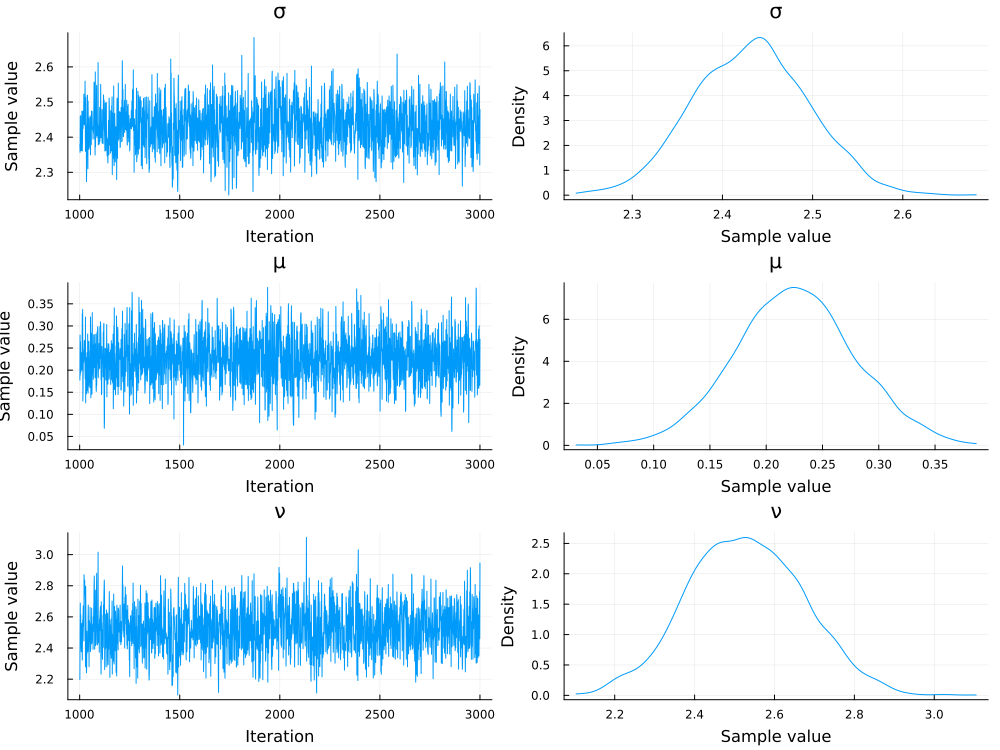

In [280]:
# To learn the Student's t-distribution:
chain_t = learn_distribution_mcmc(StudentTModel(), Rᵢ);

# You can now analyze chain_t and chain_laplace as before
plot(chain_t)


Next, for a direct comparison, we fit the **Laplace distribution** using the same MCMC methodology. This will produce a `chain` object containing posteriors for the Laplace parameters: mean (`μ`) and scale (`b`).

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


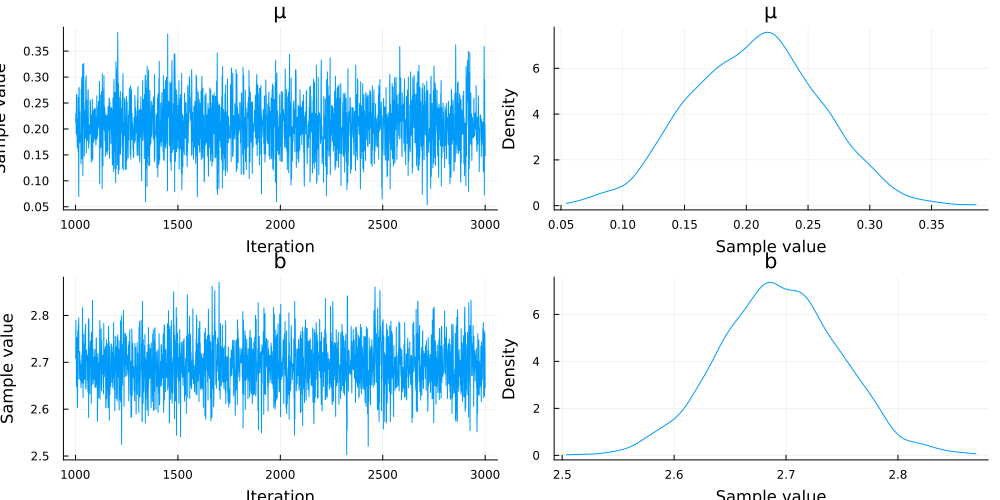

In [281]:
# To learn the Laplace distribution:
chain_laplace = learn_distribution_mcmc(LaplaceModel(), Rᵢ);

plot(chain_laplace)


Finally, we will prepare all of our fitted models for a head-to-head comparison. We will use the traditional **Maximum Likelihood Estimation (MLE)** to fit a Laplace distribution as a baseline. Then, we will bring together all the models—both MCMC and MLE—for a final comparison using visual plots and quantitative statistics.

In [282]:
# --- Prepare All Four Models ---

# 1. MLE Model
Laplace_MLE = fit_mle(Laplace, Rᵢ);

# 2. MCMC Models 
μ_t_mean = mean(chain_t[:μ])
σ_t_mean = mean(chain_t[:σ])
ν_t_mean = mean(chain_t[:ν])
StudentT_MCMC = LocationScale(μ_t_mean, σ_t_mean, TDist(ν_t_mean))

μ_laplace_mean = mean(chain_laplace[:μ])
b_laplace_mean = mean(chain_laplace[:b])
Laplace_MCMC = Laplace(μ_laplace_mean, b_laplace_mean);


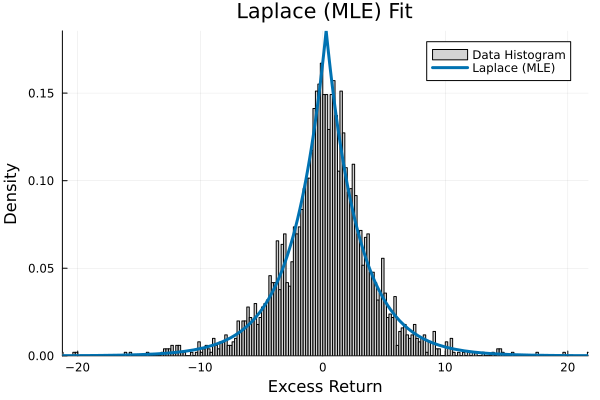

In [283]:
# --- Plot 1: Laplace (MLE) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Laplace (MLE) distribution
plot!(x -> pdf(Laplace_MLE, x), lw=3, label="Laplace (MLE)", c="#0072B2") # Blue

title!("Laplace (MLE) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

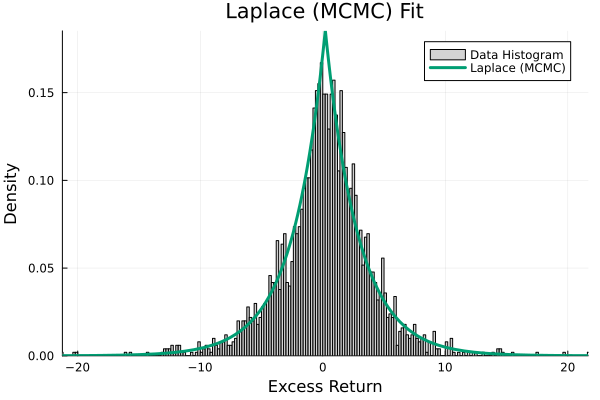

In [284]:
# --- Plot 3: Laplace (MCMC) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Laplace (MCMC) distribution
plot!(x -> pdf(Laplace_MCMC, x), lw=3, label="Laplace (MCMC)", c="#009E73") # Bluish Green

title!("Laplace (MCMC) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

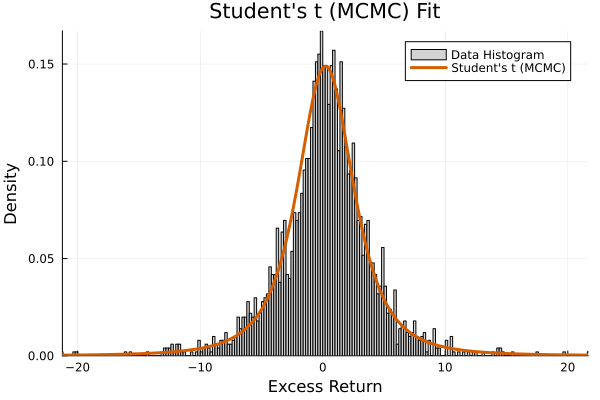

In [285]:
# --- Plot 2: Student's t (MCMC) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Student's t (MCMC) distribution
plot!(x -> pdf(StudentT_MCMC, x), lw=3, label="Student's t (MCMC)", c="#D55E00") # Vermillion/Orange

title!("Student's t (MCMC) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

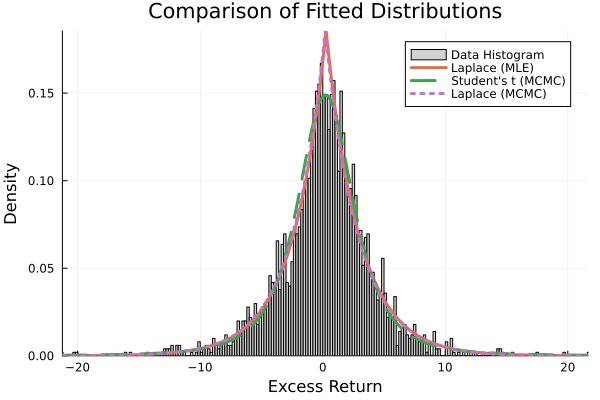

In [286]:
# ---  Visual Comparison of Four Distributions ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the four models
plot!(x -> pdf(Laplace_MLE, x), lw=3, label="Laplace (MLE)")
plot!(x -> pdf(StudentT_MCMC, x), lw=3, label="Student's t (MCMC)", ls=:dash)
plot!(x -> pdf(Laplace_MCMC, x), lw=3, label="Laplace (MCMC)", ls=:dot)

title!("Comparison of Fitted Distributions")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

In [287]:
# --- UPDATED: Quantitative Comparison of Four Distributions ---

# A. Summary Statistics
println("--- Summary Statistics ---")
println("Laplace (MLE):")
println("  Mean:      ", mean(Laplace_MLE))
println("  Variance:  ", var(Laplace_MLE))
println("  Kurtosis:  ", kurtosis(Laplace_MLE))

println("\nStudent's t (MCMC):")
println("  Mean:      ", mean(StudentT_MCMC))
println("  Variance:  ", var(StudentT_MCMC))
println("  Kurtosis:  ", kurtosis(StudentT_MCMC))

println("\nLaplace (MCMC):")
println("  Mean:      ", mean(Laplace_MCMC))
println("  Variance:  ", var(Laplace_MCMC))
println("  Kurtosis:  ", kurtosis(Laplace_MCMC))


# B. AIC Comparison (Lower is Better)
log_like_L_MLE = loglikelihood(Laplace_MLE, Rᵢ)
log_like_T_MCMC = loglikelihood(StudentT_MCMC, Rᵢ)
log_like_L_MCMC = loglikelihood(Laplace_MCMC, Rᵢ)

aic_L_MLE = 2*2 - 2*log_like_L_MLE
aic_T_MCMC = 2*3 - 2*log_like_T_MCMC
aic_L_MCMC = 2*2 - 2*log_like_L_MCMC

println("\n--- Model Comparison (Lower AIC is Better) ---")
println("AIC for Laplace (MLE):       ", aic_L_MLE)
println("AIC for Laplace (MCMC):      ", aic_L_MCMC)
println("AIC for Student's t (MCMC):  ", aic_T_MCMC)

--- Summary Statistics ---
Laplace (MLE):
  Mean:      0.275472995742301
  Variance:  14.499370724613431
  Kurtosis:  3.0

Student's t (MCMC):
  Mean:      0.22573818100813633
  Variance:  28.303445921294642
  Kurtosis:  Inf

Laplace (MCMC):
  Mean:      0.20691564223943307
  Variance:  14.516045550841904
  Kurtosis:  3.0

--- Model Comparison (Lower AIC is Better) ---
AIC for Laplace (MLE):       13497.272610885935
AIC for Laplace (MCMC):      13498.73899269644
AIC for Student's t (MCMC):  13534.361765688873


In [288]:
# Choose one of these to be your distribution in the variable d that will be used for generating CDF
d = Laplace_MLE;  # StudentT_MCMC or Laplace_MCMC or Laplace_MLE

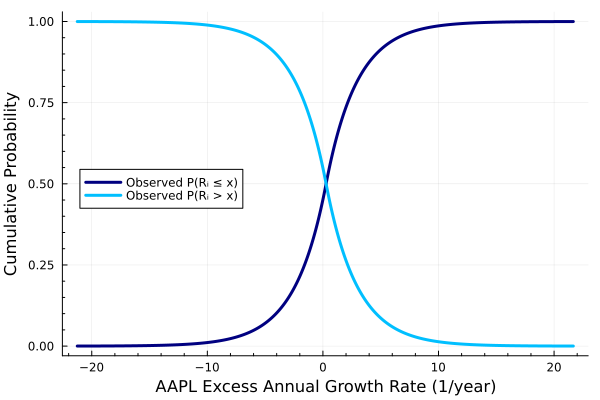

In [289]:
let

    # regions of return -
    number_of_samples = 1000;
    minimum_obs_growth = minimum(in_sample_dataset);
    maximum_obs_growth = maximum(in_sample_dataset);
    RA = range(minimum_obs_growth,stop = maximum_obs_growth, length = number_of_samples) |> collect;

    X = Array{Float64,2}(undef, number_of_samples,2);
    for i ∈ eachindex(RA)

        X[i,1] = RA[i];
        X[i,2] = cdf(d, RA[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="Observed P(Rᵢ ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="Observed P(Rᵢ > x)", legend=:left)

    xlabel!("$(ticker) Excess Annual Growth Rate (1/year)", fontsize=18);
    ylabel!("Cumulative Probability", fontsize=18);
end

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [290]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect

351-element Vector{Float64}:
 0.0
 0.002857142857142857
 0.005714285714285714
 0.008571428571428572
 0.011428571428571429
 0.014285714285714285
 0.017142857142857144
 0.02
 0.022857142857142857
 0.025714285714285714
 0.02857142857142857
 0.03142857142857143
 0.03428571428571429
 ⋮
 0.9685714285714285
 0.9714285714285714
 0.9742857142857143
 0.9771428571428571
 0.98
 0.9828571428571429
 0.9857142857142858
 0.9885714285714285
 0.9914285714285714
 0.9942857142857143
 0.9971428571428571
 1.0

Now that we have the cutoffs, compute the lower and upper bound for each potentiual category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x`
for which `cdf(d, x) ≥ q`.

In [291]:
bounds = Array{Float64,2}(undef, number_of_states, 3)
for s ∈ states
    bounds[s,1] = quantile(d,percentage_cutoff[s])
    bounds[s,2] = quantile(d,percentage_cutoff[s+1])
    bounds[s,3] = s
end
bounds

350×3 Matrix{Float64}:
 -Inf       -13.6308     1.0
 -13.6308   -11.7645     2.0
 -11.7645   -10.6728     3.0
 -10.6728    -9.89821    4.0
  -9.89821   -9.29739    5.0
  -9.29739   -8.80648    6.0
  -8.80648   -8.39143    7.0
  -8.39143   -8.03189    8.0
  -8.03189   -7.71476    9.0
  -7.71476   -7.43107   10.0
  -7.43107   -7.17445   11.0
  -7.17445   -6.94017   12.0
  -6.94017   -6.72465   13.0
   ⋮                   
   7.49111    7.72539  339.0
   7.72539    7.98202  340.0
   7.98202    8.2657   341.0
   8.2657     8.58284  342.0
   8.58284    8.94237  343.0
   8.94237    9.35743  344.0
   9.35743    9.84833  345.0
   9.84833   10.4492   346.0
  10.4492    11.2237   347.0
  11.2237    12.3155   348.0
  12.3155    14.1818   349.0
  14.1818    Inf       350.0

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:
* Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [292]:
encoded_in_sample = Array{Int64,1}();
for i ∈ eachindex(in_sample_dataset)
    value = in_sample_dataset[i];

    class_index = 1;
    for s ∈ states
        if (bounds[s,1] ≤ value && value < bounds[s,2])
            class_index = s;
            break;
        end
    end
    push!(encoded_in_sample, class_index);
end
encoded_in_sample

2514-element Vector{Int64}:
  75
 165
 211
  92
  52
 238
 284
 333
  98
  35
 175
 288
 123
   ⋮
 306
 248
 111
  62
 222
 130
  80
 115
 100
 117
 248
  82

This cell can be used to check the most frequent hidden state.

In [293]:
counts = countmap(encoded_in_sample) |> argmax;

In the matrix $\mathbf{T}$ compute the `counts` for transition from state `i` to state `j`:

In [294]:
T = zeros(number_of_states, number_of_states)
number_insample = length(encoded_in_sample);
for i ∈ 2:number_insample
    start_index = encoded_in_sample[i-1];
    stop_index = encoded_in_sample[i];
    T[start_index,stop_index] += 1;
end
T

350×350 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

From the `counts` matrix $\mathbf{T}$, compute the transtion probability matrix $\hat{\mathbf{T}}$:

In [295]:
T̂ = zeros(number_of_states, number_of_states)
for row ∈ states
    Z = sum(T[row,:]);
    for col ∈ states
        T̂[row,col] = (1/Z)*T[row,col]
    end
end
T̂

350×350 Matrix{Float64}:
 0.0  0.0       0.166667  0.0       …  0.0       0.0  0.0  0.166667
 0.0  0.0       0.0       0.0          0.0       0.0  0.0  0.0666667
 0.0  0.2       0.0       0.0          0.0       0.0  0.0  0.0
 0.0  0.333333  0.0       0.0          0.0       0.0  0.0  0.0
 0.0  0.0       0.0       0.0          0.0       0.0  0.0  0.0
 0.0  0.142857  0.0       0.0       …  0.0       0.0  0.0  0.0
 0.0  0.0       0.0       0.0          0.0       0.0  0.0  0.0
 0.0  0.125     0.125     0.0          0.0       0.0  0.0  0.125
 0.0  0.0       0.0       0.142857     0.0       0.0  0.0  0.0
 0.0  0.0       0.0       0.0          0.0       0.0  0.0  0.0
 0.0  0.0       0.0       0.2       …  0.0       0.0  0.0  0.0
 0.1  0.0       0.0       0.0          0.0       0.0  0.0  0.0
 0.0  0.0       0.0       0.0          0.0       0.0  0.0  0.0
 ⋮                                  ⋱                      
 0.0  0.0       0.0       0.0          0.0       0.0  0.0  0.0
 0.0  0.0       0.0 

### Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{T}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distrubution, save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄`-variable:

In [313]:
power_value = 50;
π̄ = (T̂^power_value) |> tmp -> Categorical(tmp[1,:]); # compute the stationary distribution (approx value is ok)

## Task 2: In-Sample Analysis of the Standard HMM
To do the simulation, we first build a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which holds the data for our Markov model. We use a [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.build-Tuple{Type{MyHiddenMarkovModel},%20NamedTuple}), which takes information about the `states,` the estimated transition matrix $\hat{\mathbf{T}}$, and the emission matrix $\mathbf{E}$ and returns a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which we save in the `model` variable.

In [314]:
model = build(MyHiddenMarkovModel, (
    states = states,
    T = T̂,
    E = E
));

### Implement the `MARKOV-SIMULATION` to generate hypothetical return sequences
Generate 'number_of_paths' example sequences, each containing 'number_of_steps' days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄.`
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for a `number_of_steps,` issue the command `model(start_state, number_of_steps).` This will compute a chain with `number_of_steps` starting as `start_state` and return the simulated sequence as an `array.`

In [315]:
number_of_steps = maximum_number_trading_days-1;
encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    start_state = rand(π̄);
    tmp = model(start_state, number_of_steps)
    for j ∈ 1:number_of_steps
        encoded_archive[j,i] = tmp[j]
    end
end
encoded_archive

2514×100 Matrix{Int64}:
 186  119    9   17  212  256  330  263  …  273  335  305  160  289   75  321
 155  145   21  296  253  137  336  117      46  281  226  154  158   77  281
 238   42   33  243  332  172  210  313     130  295  238  344  273  137  249
 142  263  208  112  251  278  300  214     258   84  194  342  306  310  150
  86   82   48  240  309  243  344  299     280  181   97  180  248  276   59
  23  170  128  213  143  224  342  227  …  186  255  248  302   22  265   33
 108  292   70   84  197   28  114  286     147   45  175   75   70   85  208
 129  293   58  165   38  270  288  126     273   24  328  344  104  136   48
  40  139   66  311   28   64  215   30     329   21  113  343  146  156  124
 205  126   28   38  301   29  289   95       6   24  129  281  173  326  298
 276  149  301  156   91  166  222   86  …    2  175  132  132   54  130  203
 260   37  343  115  333  161  170  280     350  293  255   74  176  274  334
 350   83  210  200  214  274  230  234 

In [316]:
actual_sample_bounds = copy(bounds);
actual_sample_bounds[1,1] = minimum(in_sample_dataset);
actual_sample_bounds[end,2] = maximum(in_sample_dataset)
actual_sample_bounds

350×3 Matrix{Float64}:
 -21.2536   -13.6308     1.0
 -13.6308   -11.7645     2.0
 -11.7645   -10.6728     3.0
 -10.6728    -9.89821    4.0
  -9.89821   -9.29739    5.0
  -9.29739   -8.80648    6.0
  -8.80648   -8.39143    7.0
  -8.39143   -8.03189    8.0
  -8.03189   -7.71476    9.0
  -7.71476   -7.43107   10.0
  -7.43107   -7.17445   11.0
  -7.17445   -6.94017   12.0
  -6.94017   -6.72465   13.0
   ⋮                   
   7.49111    7.72539  339.0
   7.72539    7.98202  340.0
   7.98202    8.2657   341.0
   8.2657     8.58284  342.0
   8.58284    8.94237  343.0
   8.94237    9.35743  344.0
   9.35743    9.84833  345.0
   9.84833   10.4492   346.0
  10.4492    11.2237   347.0
  11.2237    12.3155   348.0
  12.3155    14.1818   349.0
  14.1818    21.664    350.0

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.
* We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [317]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

Then, generate a random value for the excess return by sampling the appropriate [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). We develop `number_of_paths` trajectories, each containing `number_of_steps` values. We store these values in the `decoded_archive` variable:

In [318]:
in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    for j ∈ 1:number_of_steps
        s = encoded_archive[j,i];
        in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
    end
end
in_sample_decoded_archive # actual excess growth value

2514×100 Matrix{Float64}:
   0.441232   -0.769155   -7.94166   -6.13848    …   -2.03533      5.08859
  -0.0516573  -0.235249   -5.52252    3.43322        -1.96408      2.76919
   1.46702    -3.59239    -4.30144    1.58487        -0.385718     1.74951
  -0.296995    2.15147     0.826548  -0.947129        4.20872     -0.14649
  -1.6621     -1.78977    -3.23141    1.52897         2.58609     -2.661
  -5.25232     0.188212   -0.572651   0.926149   …    2.20294     -4.32157
  -1.03554     3.2484     -2.21505   -1.71584        -1.696        0.822516
  -0.559175    3.2519     -2.7352     0.108178       -0.41931     -3.22713
  -3.74384    -0.353617   -2.36622    4.33301        -0.0449946   -0.681177
   0.765452   -0.617754   -4.70353   -3.82019         5.62157      3.50272
   2.57991    -0.167391    3.68422   -0.0514842  …   -0.530105     0.739072
   2.03694    -3.93673     8.72129   -0.86229         2.48981      6.67294
  19.2021     -1.73797     0.868961   0.676855        5.27898      2.7571

### Visualize an example in-sample return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data.

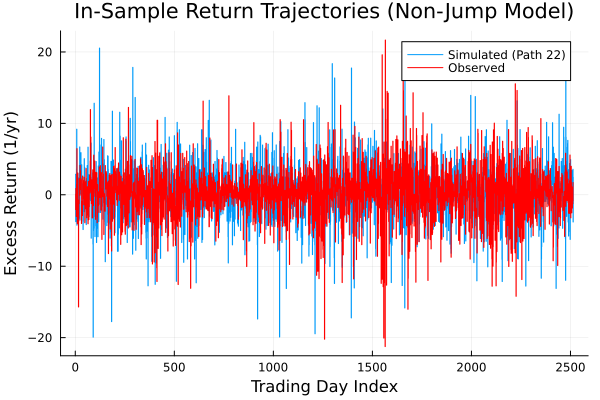

In [319]:
let
    # Select a random path to plot, just like in your working example
    index_to_plot = rand(1:number_of_paths)

    # Plot the SIMULATED data first, creating the plot
    plot(in_sample_decoded_archive[:, index_to_plot], linetype=:steppost, label="Simulated (Path $(index_to_plot))")

    # Add the OBSERVED data to the plot, slicing it to match the simulation length
    plot!(in_sample_dataset[1:(number_of_steps - 1)], linetype=:steppost, c=:red, label="Observed")
    
    # Add labels and a title
    xlabel!("Trading Day Index")
    ylabel!("Excess Return (1/yr)")
    title!("In-Sample Return Trajectories (Non-Jump Model)")
end

### Check: Are the Simulated and observed in-sample distributions the same?
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) with the hypotheses:
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Let's run [the ApproximateTwoSampleKSTest function](https://github.com/JuliaStats/HypothesisTests.jl) on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests `x` and `y` are from the same distribution):

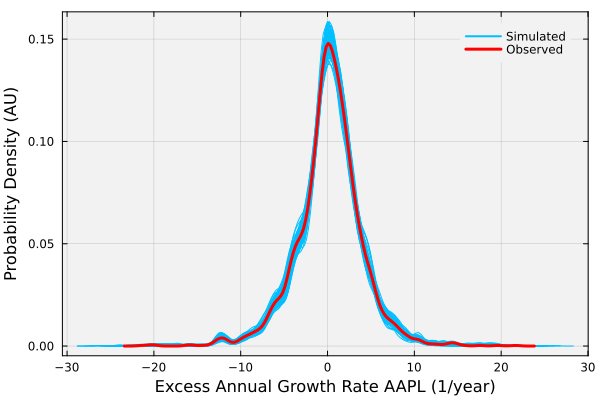

In [320]:
let
    q = plot();
    density!(in_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated",
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

In [321]:
ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0163087

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.8918

Details:
    number of observations:   [2514,2514]
    KS-statistic:              0.5782108305096809


However, we have `number_of_paths` example trajectories (not just one), so let's do the same test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [322]:
let
    pvalue_cutoff = 0.05; # cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 100.0%


#### Anderson-Darling Test
The Anderson-Darling test is another method for testing whether two samples of data come from the same distribution. A key advantage of the A-D test over the K-S test is its higher sensitivity to differences in the tails of the distributions. This is particularly relevant for financial time series, where capturing tail risk and extreme events is critical.

In [323]:
KSampleADTest(in_sample_dataset,in_sample_decoded_archive[:,rand(1:number_of_paths)])

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.1416

Details:
    number of samples:        2
    number of observations:   5028
    SD of A²k:                0.7611095325190996
    A²k statistic:            1.6610421793166745
    standardized statistic:   0.8685243727388029
    modified test:            true
    p-value calculation:      asymptotic


In [324]:
let
    pvalue_cutoff = 0.05; # cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = KSampleADTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 100.0%


#### Jensen-Shannon Divergence
The Jensen-Shannon (J-S) divergence is a method of measuring the similarity between two probability distributions, bounded between 0 (identical distributions) and 1 (maximally different distributions). Unlike the K-S and A-D tests, it is not a hypothesis test but rather a symmetric and smoothed metric of divergence, often used in information theory and for evaluating generative models.

In [325]:

# We will calculate the average J-S divergence across all simulated paths
total_jsd = 0.0;
number_of_paths = size(in_sample_decoded_archive, 2);

for i in 1:number_of_paths
    
    # Select the current simulated path
    simulated_path = in_sample_decoded_archive[:, i];
    
    # To calculate JSD, we first need to convert the continuous series into probability distributions
    # by creating histograms with a common set of bins.
    min_edge = min(minimum(in_sample_dataset), minimum(simulated_path));
    max_edge = max(maximum(in_sample_dataset), maximum(simulated_path));
    bins = range(min_edge, stop=max_edge, length=100); # Using 100 bins

    # Create normalized histograms (PDFs) from the vectors
    p = normalize(fit(Histogram, in_sample_dataset, bins), mode=:pdf);
    q = normalize(fit(Histogram, simulated_path, bins), mode=:pdf);

    # Calculate the J-S Divergence using the histogram weights and add to total
    total_jsd += js_divergence(p.weights, q.weights);
end

# Compute the average JSD
average_jsd = total_jsd / number_of_paths;

println("Average Jensen-Shannon Divergence:")
println("---------------------------------")
println("Average JSD: ", average_jsd)
println("(Value closer to 0 indicates higher similarity between the distributions)")

Average Jensen-Shannon Divergence:
---------------------------------
Average JSD: 0.014862197297114696
(Value closer to 0 indicates higher similarity between the distributions)


In [326]:
using Distances, StatsBase

# We will calculate the average KL divergence across all simulated paths
total_kl = 0.0;
number_of_paths = size(in_sample_decoded_archive, 2);
finite_paths_count = 0; # To count paths with finite KL divergence

for i in 1:number_of_paths
    
    # Select the current simulated path
    simulated_path = in_sample_decoded_archive[:, i];
    
    # Create histograms with a common set of bins
    min_edge = min(minimum(in_sample_dataset), minimum(simulated_path));
    max_edge = max(maximum(in_sample_dataset), maximum(simulated_path));
    bins = range(min_edge, stop=max_edge, length=100);

    # Create normalized histograms (PDFs)
    p = normalize(fit(Histogram, in_sample_dataset, bins), mode=:pdf);
    q = normalize(fit(Histogram, simulated_path, bins), mode=:pdf);

    # Add a small epsilon to q to avoid zeros in log calculation, which would result in infinity
    epsilon = 1e-10;
    q.weights .+= epsilon;
    q.weights ./= sum(q.weights); # Re-normalize

    # Calculate the KL Divergence and add to total if it's finite
    kl_div = kl_divergence(p.weights, q.weights);
    if isfinite(kl_div)
        total_kl += kl_div;
        finite_paths_count += 1;
    end
end

# Compute the average KL divergence over paths that yielded a finite result
average_kl = total_kl / finite_paths_count;

println("Average Kullback-Leibler Divergence:")
println("-----------------------------------")
println("Average KL: ", average_kl)
println("Calculated over ", finite_paths_count, " of ", number_of_paths, " paths with finite results.")
println("(Value closer to 0 indicates higher similarity)")

Average Kullback-Leibler Divergence:
-----------------------------------
Average KL: 2.1003617901808957
Calculated over 100 of 100 paths with finite results.
(Value closer to 0 indicates higher similarity)


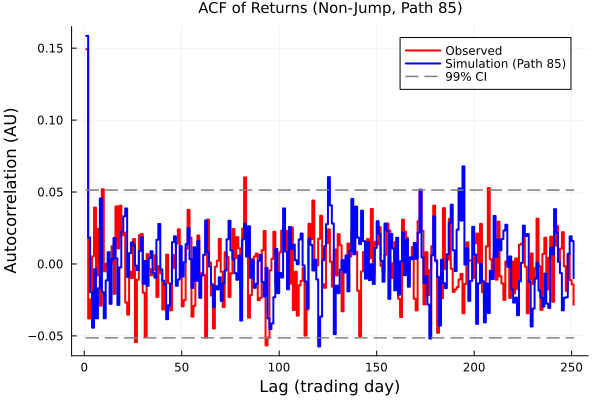

In [327]:
let
    random_index = rand(1:number_of_paths)
    simulated_path = in_sample_decoded_archive[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path, "ACF of Returns (Non-Jump, Path $(random_index))", random_index)
end

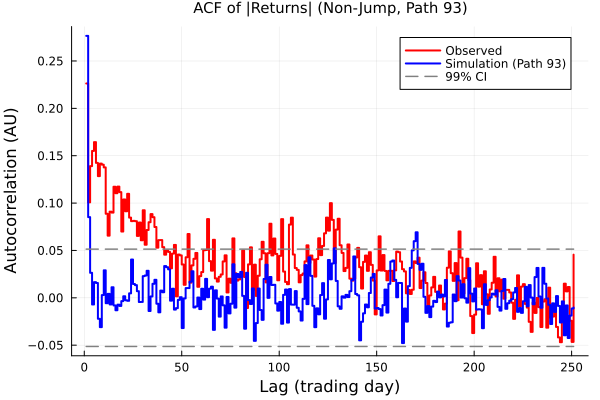

In [328]:
let
    random_index = rand(1:number_of_paths)
    simulated_path = in_sample_decoded_archive[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path, "ACF of |Returns| (Non-Jump, Path $(random_index))", random_index, is_absolute=true)
end

### Conclusion from the Non-Jump Model Analysis

The autocorrelation plots reveal a key insight:
* **Success:** The standard HMM successfully replicates the lack of significant autocorrelation in raw returns, consistent with the efficient market hypothesis.
* **Failure:** The model completely fails to reproduce the strong, persistent autocorrelation in **absolute returns**. This means the simple HMM **cannot capture volatility clustering**, a critical stylized fact of financial markets.

This failure motivates the need for a more sophisticated model, which we explore in `Simulation-Notebook-HMM-WithJumps`.

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.